In [ ]:
# Using a Wasserstein GAN (WGAN), as introduced in Google's 2017 paper https://arxiv.org/pdf/1701.07875 (the dicriminator doesn't classify instances - called a critic)
# Minimize D(x) - D(G(z)), where D(x) is the critic's output for a real instance, G(z) is the generator's output when given noise z, and D(G(z)) is the critic's output for a fake instance

import os
import numpy as np
import math
import sys
from time import time
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

os.makedirs("images", exist_ok=True)

class Opt(object):
    dim = 10
    n_epochs = 200
    batch_size = dim*dim
    lr = 0.00005
    n_cpu = 1
    latent_dim = 100
    img_size = 28
    channels = 1
    n_critic = 5
    clip_value = 0.01
    sample_interval = 400
opt = Opt()

img_shape = (opt.channels, opt.img_size, opt.img_size)

cuda = True if torch.cuda.is_available() else False

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        def block(in_feat, out_feat, normalize=True):
          layers = [nn.Linear(in_feat, out_feat)]
          if normalize:
            layers.append(nn.BatchNorm1d(out_feat, 0.8))
          layers.append(nn.LeakyReLU(0.2, inplace=True))
          return layers
        self.model = nn.Sequential(
            *block(opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        return img

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(opt.img_size ** 2, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )
    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity

#initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()

# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]),
    ),
    batch_size=opt.batch_size,
    shuffle=True,
)

#optimizers
generator_optimizer = torch.optim.RMSprop(generator.parameters(), lr=opt.lr)
discriminator_optimizer = torch.optim.RMSprop(discriminator.parameters(), lr=opt.lr)

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

#Training
batches_done = 0
saved_imgs = []
for epoch in range(opt.n_epochs):
  print("Epoch " + str(epoch) + 'training...', end='')
  start = time()
  for i, (imgs, _) in enumerate(dataloader):
      real_imgs = Variable(imgs.type(Tensor))
      #train discriminator
      discriminator_optimizer.zero_grad()
      #sample noise as generator input
      z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))
      #generate batch of images
      fake_imgs = generator(z).detach()
      #adversarial loss
      discriminator_loss = torch.mean(discriminator(fake_imgs)) - torch.mean(discriminator(real_imgs))
      discriminator_loss.backward()
      discriminator_optimizer.step()
      #clip weighs of discriminator
      for p in discriminator.parameters():
        p.data.clamp_(-opt.clip_value, opt.clip_value)
      #train generator every n_critic iterations
      if i % opt.n_critic == 0:
        #train Generator
        generator_optimizer.zero_grad()
        #generate batch of fake images
        critics_fake_imgs = generator(z)
        #adversarial loss
        generator_loss = -torch.mean(discriminator(critics_fake_imgs))
        generator_loss.backward()
        generator_optimizer.step()
      batches_done += 1
  end = time()
  elapsed = end-start
  print('done in ' + str(elapsed) + ' seconds')
  grid = torchvision.utils.make_grid(critics_fake_imgs.data.cpu(), nrow=opt.dim)
  img = (np.transpose(grid.detach().numpy(), (1,2,0)) * 255).astype(np.uint8)
  saved_imgs.append(img)

Epoch 0training...done in 30.511921405792236 seconds
Epoch 1training...done in 29.60500168800354 seconds
Epoch 2training...done in 32.447330951690674 seconds
Epoch 3training...done in 32.53955340385437 seconds
Epoch 4training...done in 30.377593517303467 seconds
Epoch 5training...done in 45.523974657058716 seconds
Epoch 6training...done in 33.01749777793884 seconds
Epoch 7training...done in 29.453677892684937 seconds
Epoch 8training...done in 29.275224208831787 seconds
Epoch 9training...done in 31.65377140045166 seconds
Epoch 10training...done in 30.603305339813232 seconds
Epoch 11training...done in 30.30885148048401 seconds
Epoch 12training...done in 30.397659063339233 seconds
Epoch 13training...done in 30.41407036781311 seconds
Epoch 14training...done in 29.350356578826904 seconds
Epoch 15training...done in 30.383015632629395 seconds
Epoch 16training...done in 29.360602378845215 seconds
Epoch 17training...done in 29.40031409263611 seconds
Epoch 18training...done in 30.29275417327881 

When trained on 0 epochs
When trained on 4 epochs
When trained on 9 epochs
When trained on 29 epochs
When trained on 49 epochs
When trained on 99 epochs
When trained on 149 epochs
When trained on 199 epochs


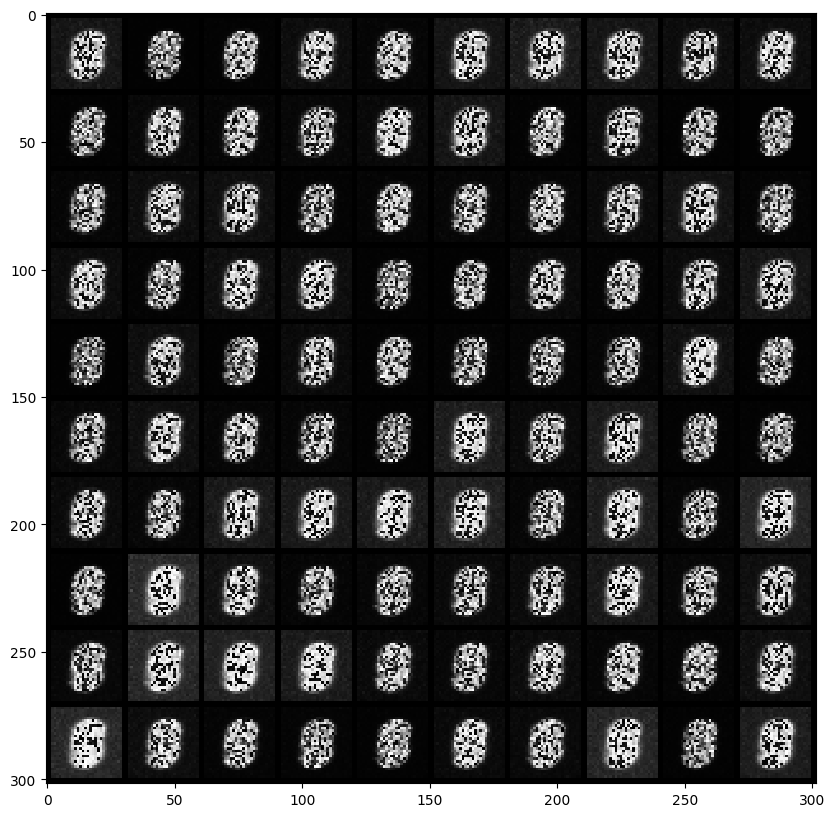

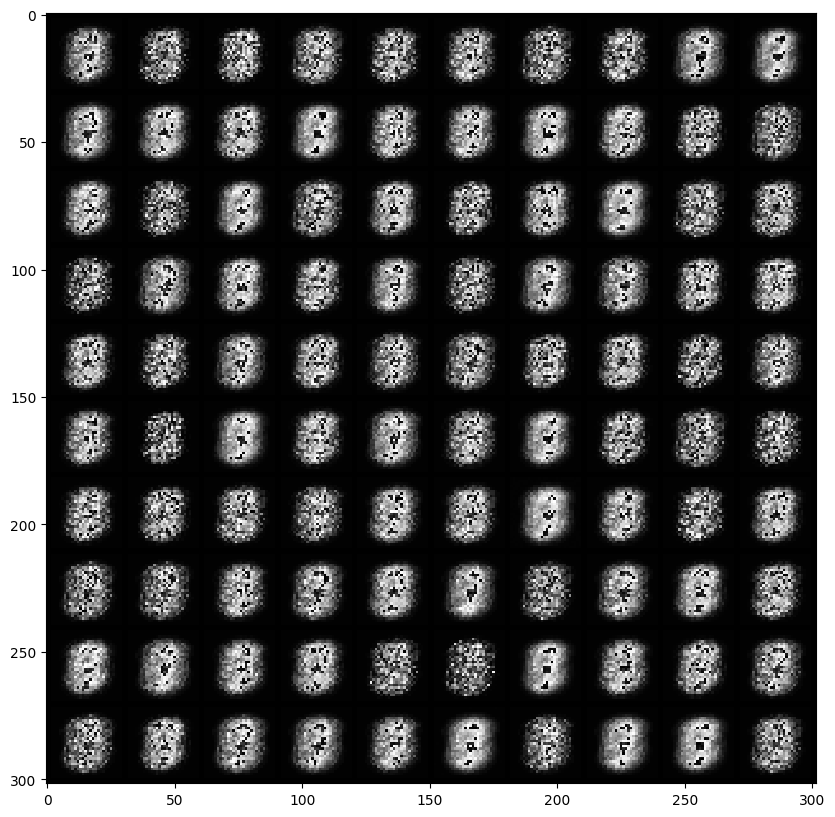

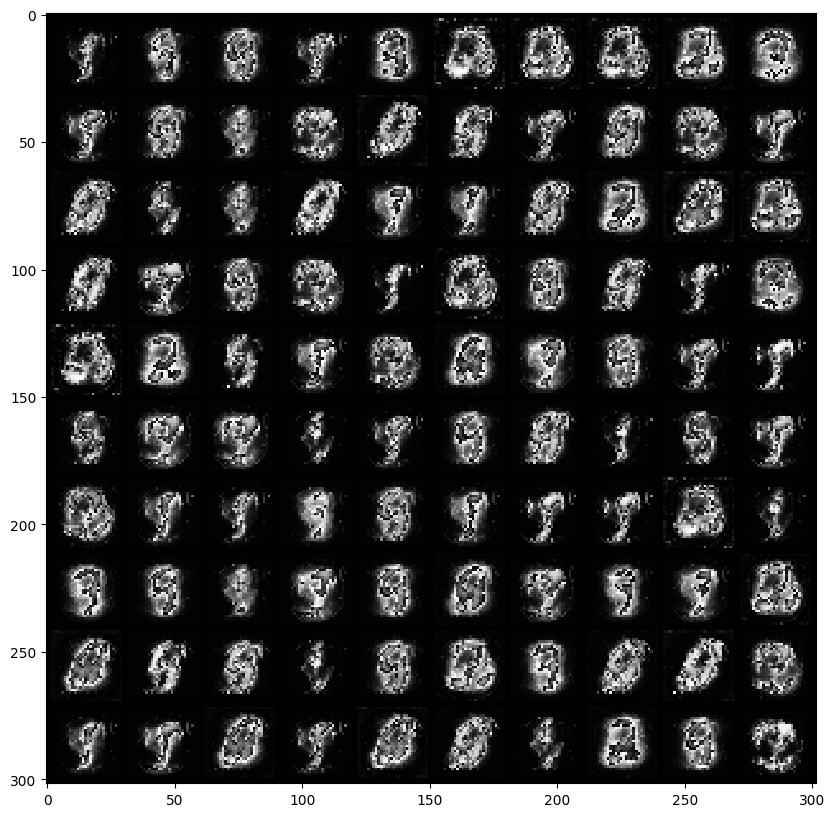

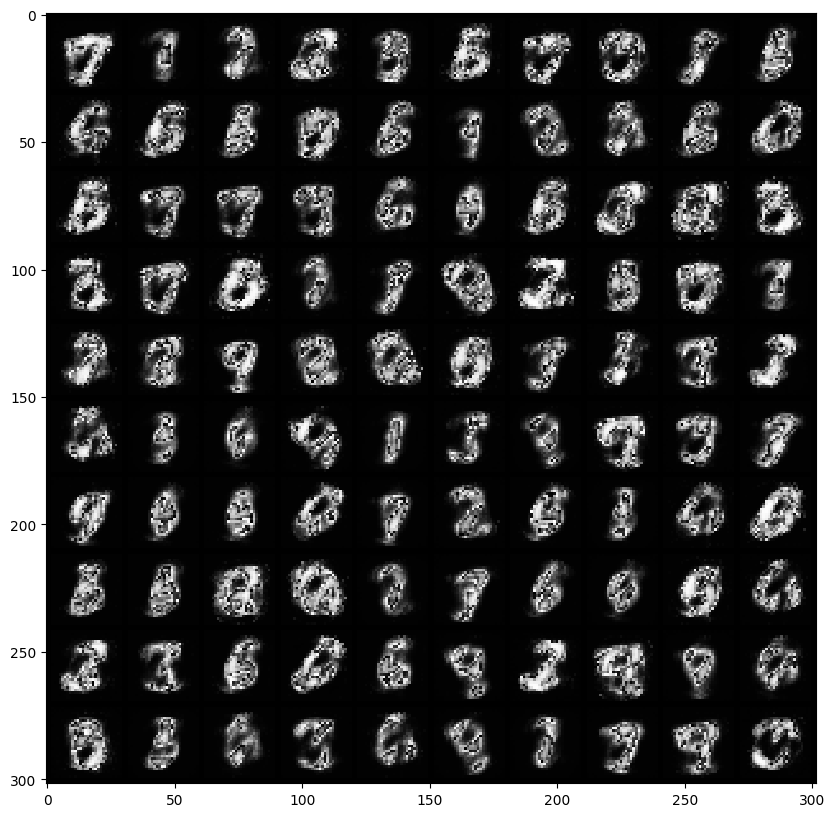

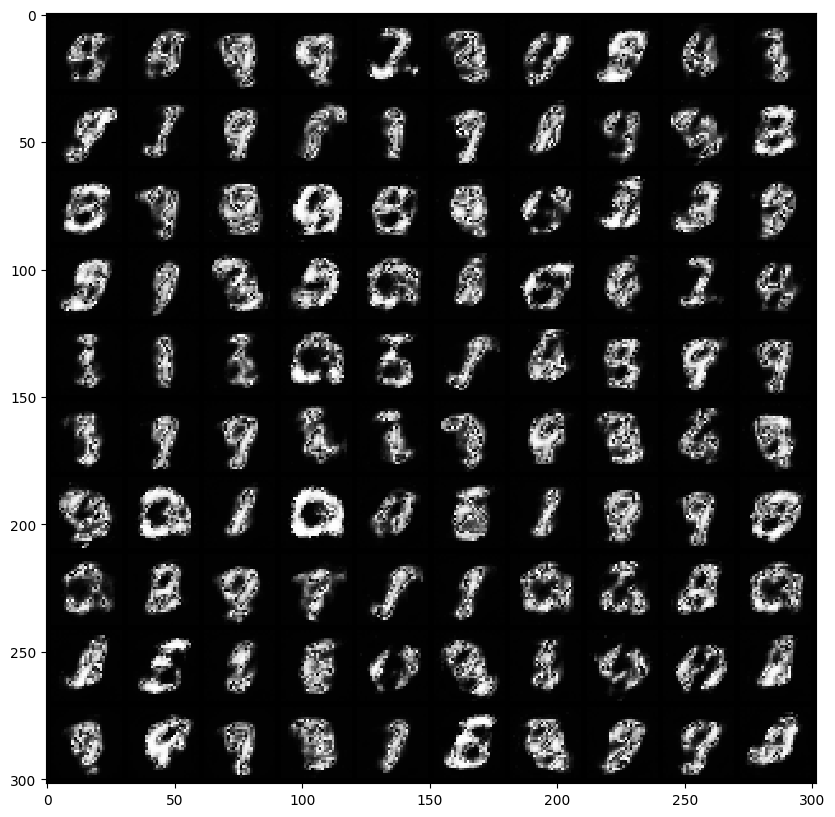

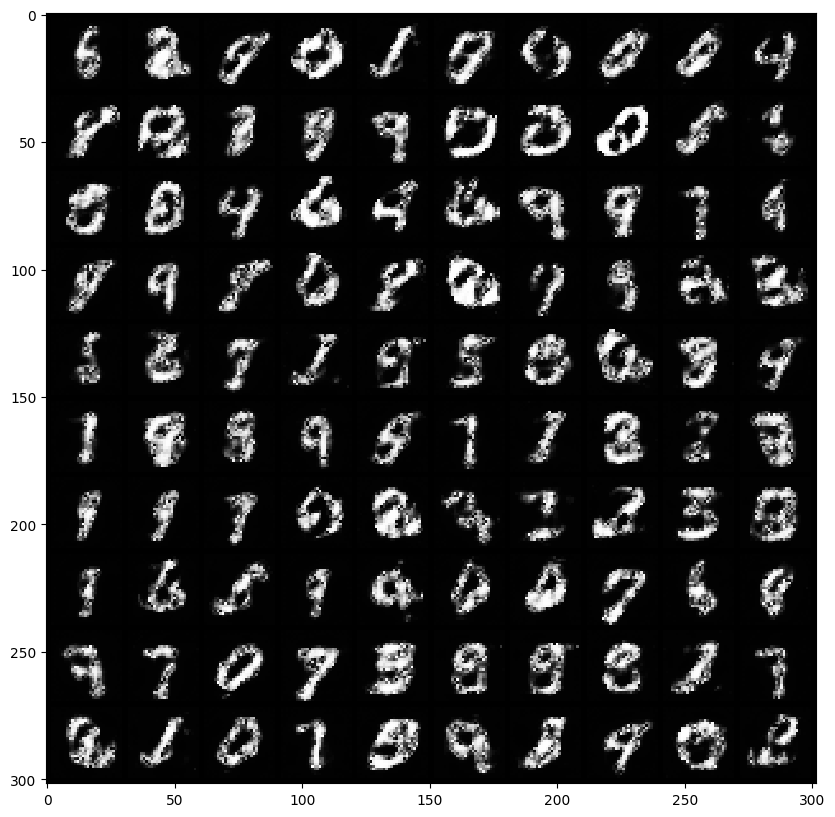

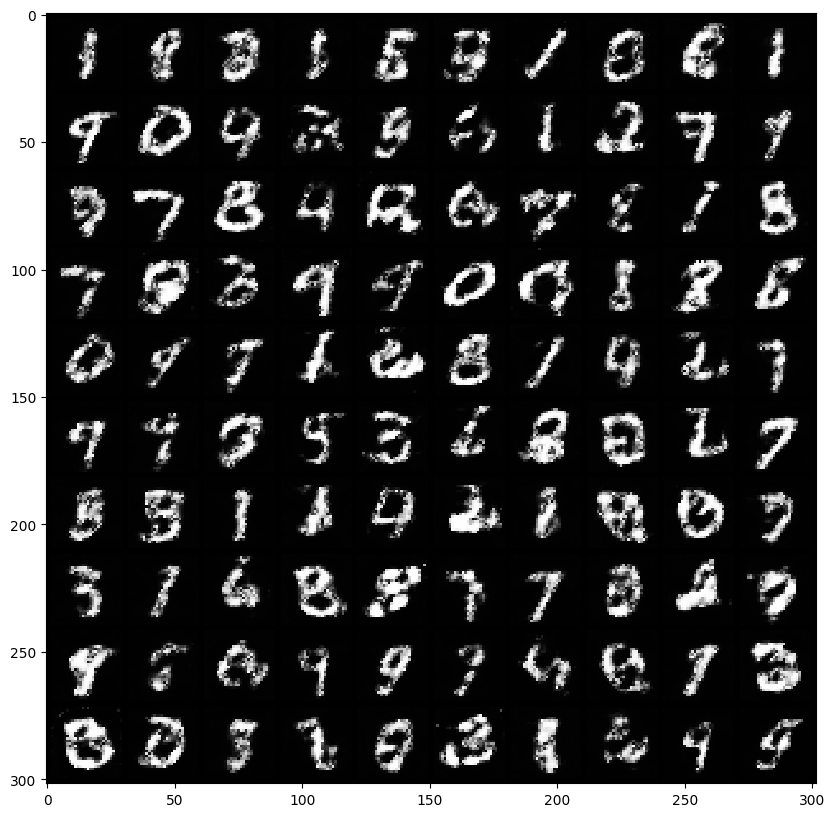

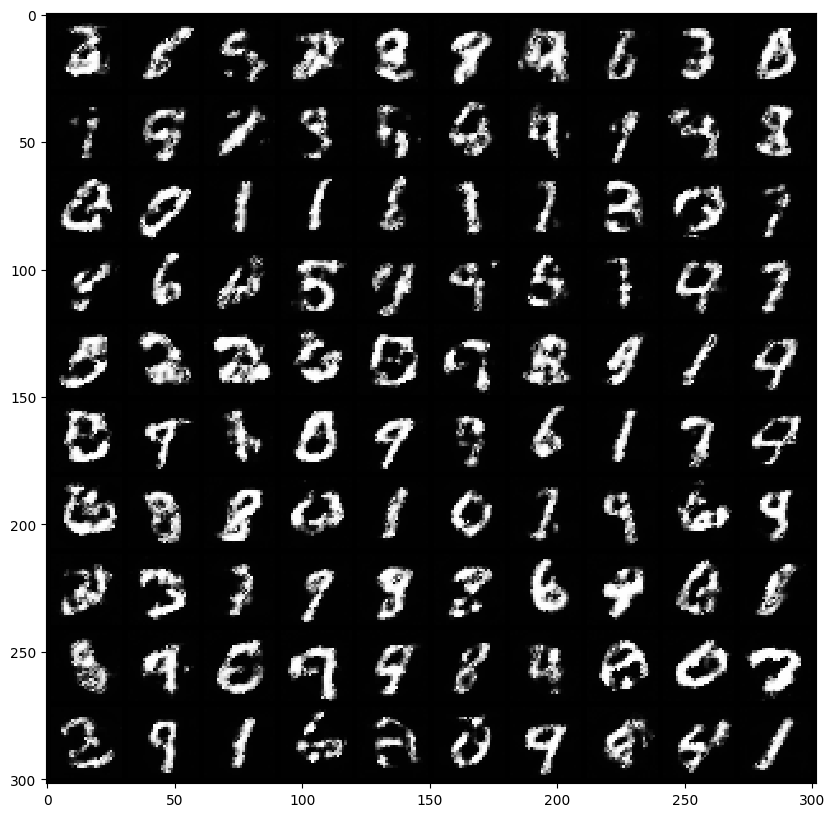

In [6]:
img_indexes = [0, 4, 9, 29, 49, 99, 149, 199]
for i in img_indexes:
  print(f"When trained on {i} epochs")
  plt.figure(figsize = (opt.dim, opt.dim))
  plt.imshow(saved_imgs[i], interpolation='nearest')